# Cassava PyTorch XLA/TPU starter
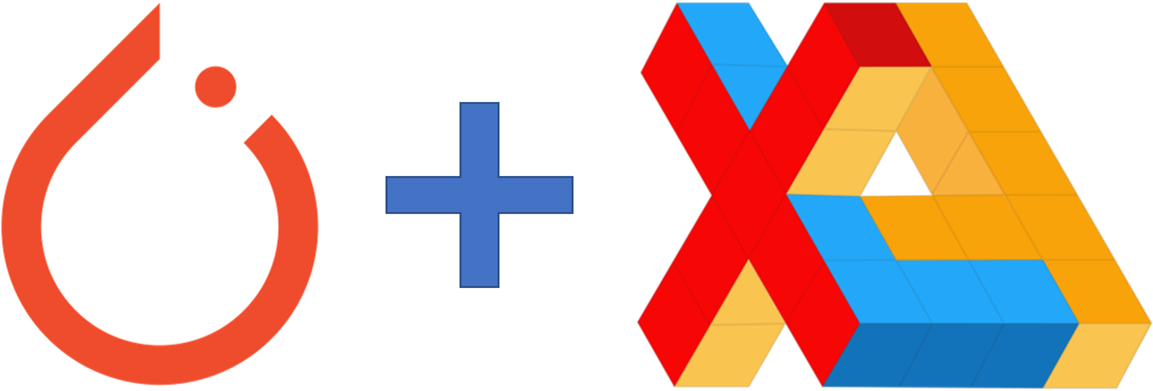

### If you found this helpful, please give it an upvote!

## Introduction

[PyTorch XLA](https://pytorch.org/xla/master) is a PyTorch library for XLA support. XLA (Accelerated Linear Algebra) is a domain-specific compiler that was originally meant for compiling and accelerating TensorFlow models. However, other packages, like JAX and now PyTorch XLA can compile program with XLA to accelerate code. TPUs can be programmed with XLA programs and PyTorch XLA provides this interface with TPUs by compiling our PyTorch code as XLA programs to run on TPU devices.

In this kernel, I provide an in-depth look into how you can use PyTorch XLA to **train a PyTorch model on the TPU** for the Cassava Leaf Disease classification competition.

## Installs & Imports

The below cell will install the PyTorch XLA package.

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py  > /dev/null
!python pytorch-xla-env-setup.py --version nightly  > /dev/null

The below cell will install the [timm]() library, which is what we will use to define our models and get pretrained weights.

In [ ]:
!pip install timm  > /dev/null

Here are all of our imports!

In [ ]:
import gc
import os
import time
import torch
import albumentations

import numpy as np
import pandas as pd

import cv2
from PIL import Image

import torch.nn as nn
from sklearn import metrics
from sklearn import model_selection
from torch.nn import functional as F
from torch.optim import Adam

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.serialization as xser


import timm

import warnings
warnings.filterwarnings("ignore")


os.environ['XLA_USE_BF16']="1"
os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

## Definitions

Now let's define the necessary functions and variables needed for training.

These are the flags for training. When you fork (after you upvote of course, ;) ), feel free to play around with these flags!

In [ ]:
FLAGS = {
    
    'fold': 0,
    'model': 'resnext50_32x4d',
    'pretrained': True,
    'batch_size': 128,
    'num_workers': 4,
    'lr': 3e-4,
    'epochs': 10
}

Here, I define a model class for the timm models.

In [ ]:
# Using Ross Wightman's timm package
class TimmModels(nn.Module):
    def __init__(self, model_name,pretrained=True, num_classes=5):
        super(TimmModels, self).__init__()
        self.m = timm.create_model(model_name,pretrained=pretrained)
        model_list = list(self.m.children())
        model_list[-1] = nn.Linear(
            in_features=model_list[-1].in_features, 
            out_features=num_classes, 
            bias=True
        )
        self.m = nn.Sequential(*model_list)
        
    def forward(self, image):
        out = self.m(image)
        return out

Here, I define a class for the PyTorch Dataset (taken from @abhishek's amazing [Tez package](https://github.com/abhishekkrthakur/tez)).

In [ ]:
# Image Dataset class taken from Abhishek's tez package

class ImageDataset:
    def __init__(
        self,
        image_paths,
        targets,
        resize,
        augmentations=None,
        backend="pil",
        channel_first=True,
    ):
        """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
        """
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations
        self.backend = backend
        self.channel_first = channel_first

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        targets = self.targets[item]
        if self.backend == "pil":
            image = Image.open(self.image_paths[item])
            if self.resize is not None:
                image = image.resize(
                    (self.resize[1], self.resize[0]), resample=Image.BILINEAR
                )
            image = np.array(image)
            if self.augmentations is not None:
                augmented = self.augmentations(image=image)
                image = augmented["image"]
        elif self.backend == "cv2":
            image = cv2.imread(self.image_paths[item])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.resize is not None:
                image = cv2.resize(
                    image,
                    (self.resize[1], self.resize[0]),
                    interpolation=cv2.INTER_CUBIC,
                )
            if self.augmentations is not None:
                augmented = self.augmentations(image=image)
            image = augmented["image"]
        else:
            raise Exception("Backend not implemented")
        if self.channel_first:
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            "image": torch.tensor(image),
            "targets": torch.tensor(targets),
        }

I now create my folds. Of course, you can replace with your own folds here.

In [ ]:
# create folds
df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
df["kfold"] = -1    
df = df.sample(frac=1).reset_index(drop=True)
y = df.label.values
kf = model_selection.StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

df.to_csv("train_folds.csv", index=False)

## Training code

Let's start training! To do so, we start by initializing the model. We use the `xmp.MpModelWrapper` provided by PyTorch XLA to save memory when initializing the model.

In [ ]:
MX = xmp.MpModelWrapper(TimmModels(FLAGS['model'],pretrained=FLAGS['pretrained'], num_classes=5))

Let's now define our training and validationfunctions. 

In [ ]:
def train_loop_fn(data_loader, loss_fn, model, optimizer, device, scheduler=None):
    model.train() # put model in training mode
    for bi, d in enumerate(data_loader): # enumerate through the dataloader
        
        images = d['image'] # obtain the ids
        targets = d['targets'] # obtain the target

        # pass image to model
        optimizer.zero_grad()
        outputs = model(images)
        
        # calculate loss
        loss = loss_fn(outputs, targets)
        
        # backpropagate
        loss.backward()
        
        # Use PyTorch XLA optimizer stepping
        xm.optimizer_step(optimizer)
        
        # Step the scheduler
        if scheduler is not None: scheduler.step()
    
    # since the loss is on all 8 cores, reduce the loss values and print the average
    loss_reduced = xm.mesh_reduce('loss_reduce',loss, lambda x: sum(x) / len(x)) 
    # master_print will only print once (not from all 8 cores)
    xm.master_print(f'bi={bi}, train loss={loss_reduced}')
        
    model.eval() # put model in eval mode for later use
    
def eval_loop_fn(data_loader, loss_fn, model, device):
    fin_targets = []
    fin_outputs = []
    for bi, d in enumerate(data_loader): # enumerate through dataloader
        
        images = d['image'] # obtain the ids
        targets = d['targets']# # obtain the targets


        # pass image to model
        with torch.no_grad(): outputs = model(images)

        # Add the outputs and targets to a list 
        targets_np = targets.cpu().detach().numpy().tolist()
        outputs_np = outputs.cpu().detach().numpy().tolist()
        fin_targets.extend(targets_np)
        fin_outputs.extend(outputs_np)    
        del targets_np, outputs_np
        gc.collect() # delete for memory conservation
                
    o,t = np.array(fin_outputs), np.array(fin_targets)
    
    # calculate loss
    loss = loss_fn(torch.tensor(o), torch.tensor(t))
    # since the loss is on all 8 cores, reduce the loss values and print the average
    loss_reduced = xm.mesh_reduce('loss_reduce',loss, lambda x: sum(x) / len(x)) 
    # master_print will only print once (not from all 8 cores)
    xm.master_print(f'val. loss={loss_reduced}')
    
    acc = metrics.accuracy_score(t,o.argmax(axis=1))
    acc_reduced = xm.mesh_reduce('acc_reduce', acc, lambda x: sum(x) / len(x))
        
    xm.master_print(f'val. accuracy = {acc_reduced}')

Finally, we define a main function that we will run on each of the 8 cores of the TPU.

In [ ]:
def run(rank, flags):
    global FLAGS
    torch.set_default_tensor_type('torch.FloatTensor')
    
    training_data_path = "../input/cassava-jpeg-256x256/kaggle/train_images_jpeg" #define the dataset path
    df = pd.read_csv("/kaggle/working/train_folds.csv") #read train csv created earlier
    device = xm.xla_device() #device, will be different for each core on the TPU
    epochs = FLAGS['epochs']
    fold = FLAGS['fold']
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    train_aug = albumentations.Compose(
        [
            albumentations.Normalize(
                mean, 
                std, 
                max_pixel_value=255.0, 
                always_apply=True
            ),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
        ]
    )

    valid_aug = albumentations.Compose(
        [
            albumentations.Normalize(
                mean, 
                std, 
                max_pixel_value=255.0,
                always_apply=True
            )
        ]
    )

    train_images = df_train.image_id.values.tolist()
    train_images = [
        os.path.join(training_data_path, i) for i in train_images
    ]
    train_targets = df_train.label.values

    valid_images = df_valid.image_id.values.tolist()
    valid_images = [
        os.path.join(training_data_path, i) for i in valid_images
    ]
    valid_targets = df_valid.label.values
    
    
    train_dataset = ImageDataset(
        image_paths=train_images,
        targets=train_targets,
        resize=None,
        augmentations=train_aug,
    )
    
    valid_dataset = ImageDataset(
        image_paths=valid_images,
        targets=valid_targets,
        resize=None,
        augmentations=valid_aug,
    )
    
    # special sampler needed for distributed/multi-core (divides dataset among the replicas/cores/devices)
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(), #divide dataset among this many replicas
        rank=xm.get_ordinal(), #which replica/device/core
        shuffle=True)
    
    # define DataLoader with the defined sampler
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=FLAGS['batch_size'],
        sampler=train_sampler,
        num_workers=FLAGS['num_workers'],
        drop_last=True)
    
    # same as train but with valid data
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=FLAGS['batch_size'],
        sampler=valid_sampler,
        num_workers=FLAGS['num_workers'],
        drop_last=False)
    
    train_loader = pl.MpDeviceLoader(train_loader, device) # puts the train data onto the current TPU core
    valid_loader = pl.MpDeviceLoader(valid_loader, device) # puts the valid data onto the current TPU core

    model = MX.to(device) # put model onto the current TPU core
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=FLAGS['lr']*xm.xrt_world_size()) # often a good idea to scale the learning rate by number of cores
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader)*FLAGS['epochs']) #let's use a scheduler

    gc.collect()
    
    xm.master_print(f'========== training fold {FLAGS["fold"]} for {FLAGS["epochs"]} epochs ==========')
    for i in range(FLAGS['epochs']):
        xm.master_print(f'EPOCH {i}:')
        # train one epoch
        train_loop_fn(train_loader, loss_fn, model, optimizer, device, scheduler)
                
        # validation one epoch
        eval_loop_fn(valid_loader, loss_fn, model, device)

        gc.collect()
    
    xm.rendezvous('save_model')
    
    xm.master_print('save model')
    
    xm.save(model.state_dict(), f'xla_trained_model_{FLAGS["epochs"]}_epochs_fold_{FLAGS["fold"]}.pth')

Let's train all 5 folds!

In [ ]:
for i in range(5):
    FLAGS['fold'] = i
    start_time = time.time()
    xmp.spawn(run, args=(FLAGS,), nprocs=8, start_method='fork')
    print('time taken: ', time.time()-start_time)
    print('==============================================================================')

Now, **WE ARE DONE!**

If you enjoyed this kernel, please give it an upvote. If you have any questions or suggestions, please leave a comment!

Also, check out my [related kernel](https://www.kaggle.com/tanlikesmath/the-ultimate-pytorch-tpu-tutorial-jigsaw-xlm-r) with more detailed information on PyTorch XLA/TPU training.